### 0. Imports and setup

In [1]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from src.coloring import random_color, add_dimension
from mpl_toolkits.mplot3d import Axes3D
from src.nn import UNet, ResNet_D
from src.plot import plot_img_3D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [3]:
BATCH_SIZE = 32

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    transforms.RandomRotation(45),
    random_color,
    add_dimension,
])
#  Load train datasets
mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)
indices = mnist_train_a.targets == 3
mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]
mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)
indices = mnist_train_b.targets == 5
mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]
mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)
indices = mnist_test.targets == 3
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]
mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

/home/polosatik/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's plot a number:

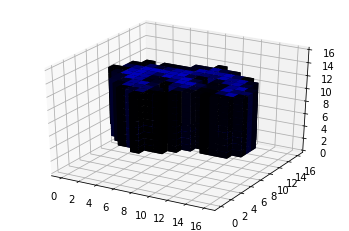

In [4]:
img = next(iter(mnist_train_a))[0]
plot_img(img)
plot_img_3D(img)

### 3. Preparation for the training

In [7]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [8]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [9]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)[0]
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)[0]

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)[0]
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)[0]

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)[0]
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)[0]

In [10]:
def save_model(e, t, F, o_t, o_F, l_t, l_F, path):
    torch.save({
                'epoch': e,
                'T_state_dict': t.state_dict(),
                'f_state_dict': F.state_dict(),
                'T_optimizer_state_dict': o_t.state_dict(),
                'f_optimizer_state_dict': o_F.state_dict(),
                'T_loss': l_t,
                'f_loss': l_F
                }, path)

In [11]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [12]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

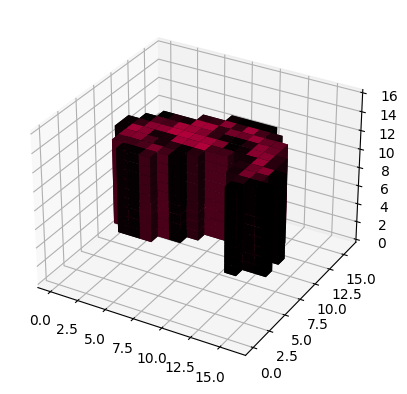

  0%|          | 0/4001 [00:00<?, ?it/s]

T_loss: 0.08742842078208923;  f_loss: 0.0026931033935397863


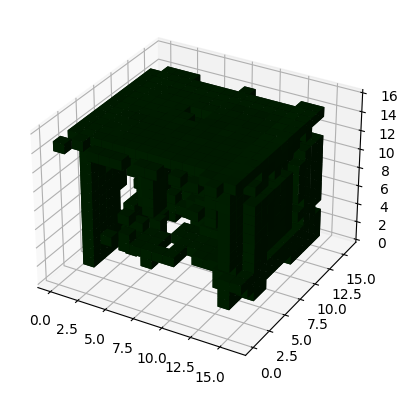

  2%|▏         | 100/4001 [01:09<44:53,  1.45it/s]

T_loss: -0.050925374031066895;  f_loss: -0.0005502626299858093


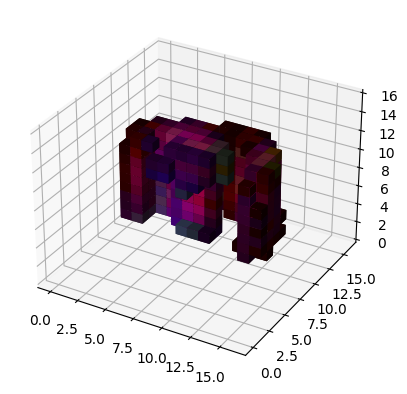

  5%|▍         | 200/4001 [02:19<44:13,  1.43it/s]

T_loss: -0.023809537291526794;  f_loss: -0.0041118524968624115


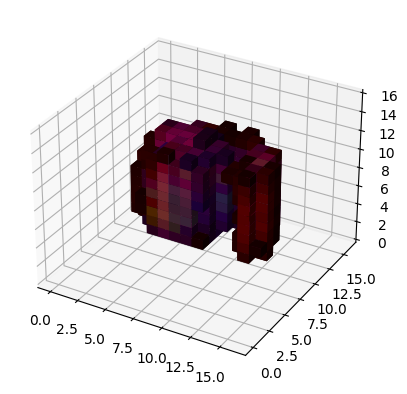

  7%|▋         | 300/4001 [03:29<43:01,  1.43it/s]

T_loss: 0.08655264973640442;  f_loss: -0.004057526588439941


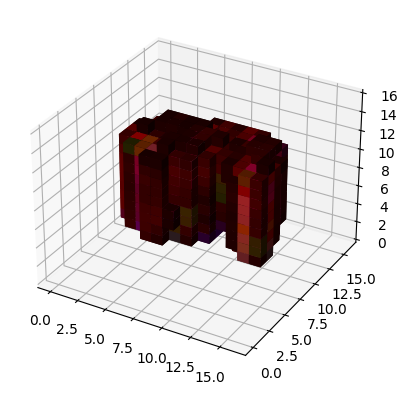

 10%|▉         | 400/4001 [04:39<41:57,  1.43it/s]

T_loss: 0.762005090713501;  f_loss: -0.21238547563552856


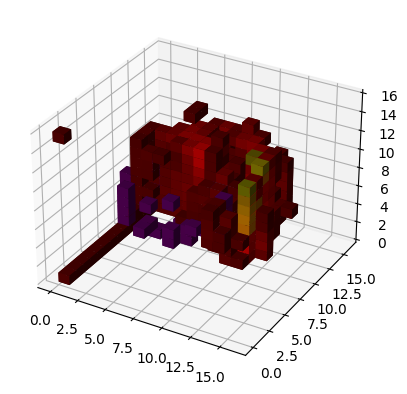

 12%|█▏        | 500/4001 [05:49<40:46,  1.43it/s]

T_loss: 0.12674355506896973;  f_loss: 0.002035766839981079


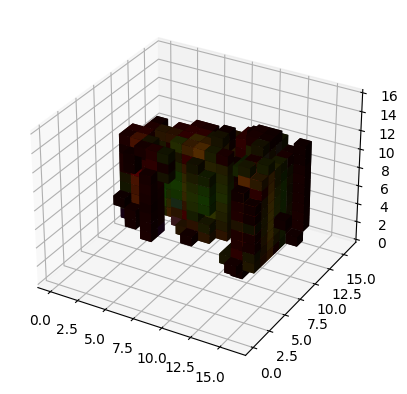

 15%|█▍        | 600/4001 [06:59<39:32,  1.43it/s]

T_loss: 0.21989746391773224;  f_loss: -0.010108783841133118


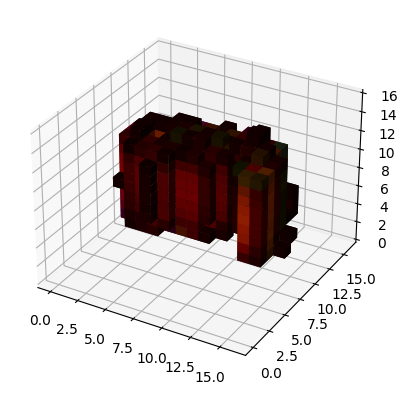

 17%|█▋        | 700/4001 [08:10<38:14,  1.44it/s]

T_loss: 1.4022966623306274;  f_loss: 0.0065506696701049805


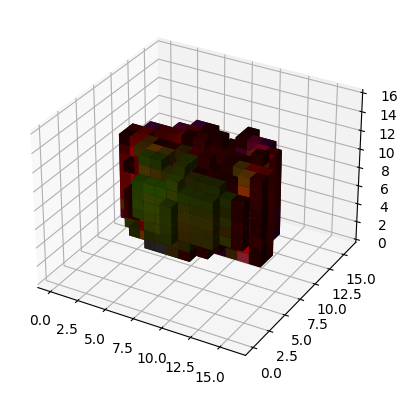

 20%|█▉        | 800/4001 [09:20<37:15,  1.43it/s]

T_loss: 0.6780663132667542;  f_loss: 0.009588479995727539


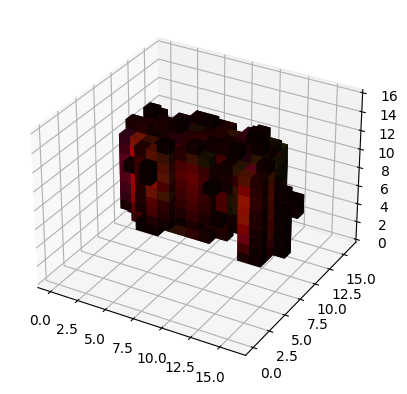

 22%|██▏       | 900/4001 [10:30<36:08,  1.43it/s]

T_loss: 0.8345005512237549;  f_loss: -0.08190381526947021


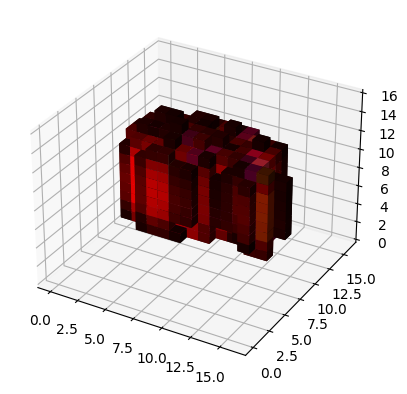

 25%|██▍       | 1000/4001 [11:40<34:52,  1.43it/s]

T_loss: 0.12728248536586761;  f_loss: -0.007628343999385834


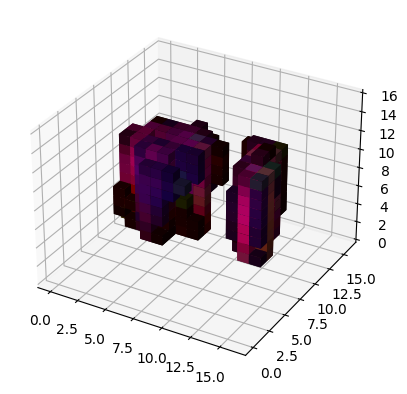

 27%|██▋       | 1100/4001 [12:50<33:31,  1.44it/s]

T_loss: 0.34124210476875305;  f_loss: -0.029517143964767456


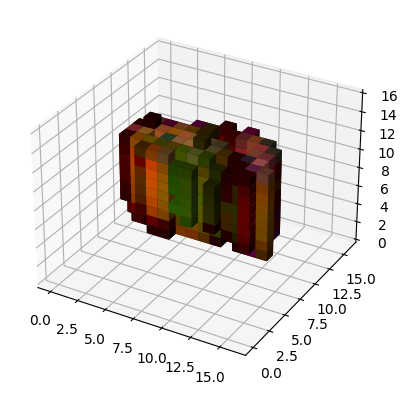

 30%|██▉       | 1200/4001 [14:00<32:34,  1.43it/s]

T_loss: -0.01398541685193777;  f_loss: -0.006057564169168472


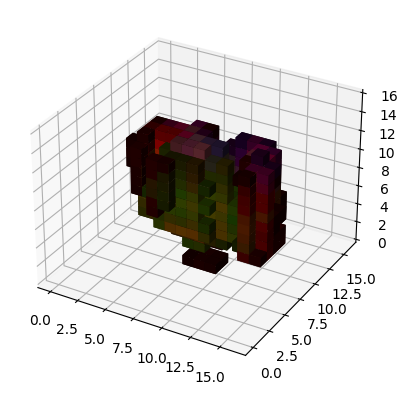

 32%|███▏      | 1300/4001 [15:11<31:25,  1.43it/s]

T_loss: -1.2529526948928833;  f_loss: 0.12209105491638184


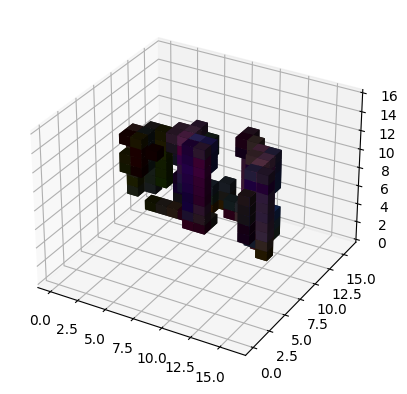

 35%|███▍      | 1400/4001 [16:21<30:12,  1.44it/s]

T_loss: -0.4435758590698242;  f_loss: -0.02211281657218933


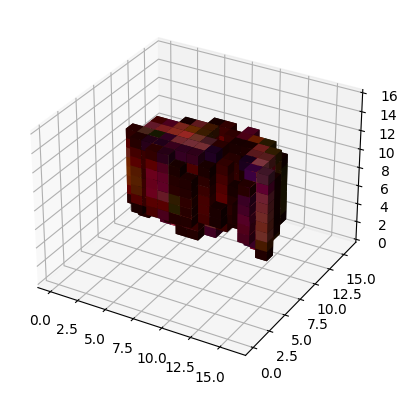

 37%|███▋      | 1500/4001 [17:31<29:07,  1.43it/s]

T_loss: -0.2327396422624588;  f_loss: -0.02377304434776306


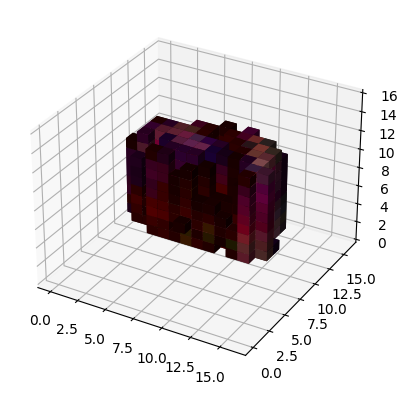

 40%|███▉      | 1600/4001 [18:41<27:56,  1.43it/s]

T_loss: -0.4150262176990509;  f_loss: 4.882549285888672


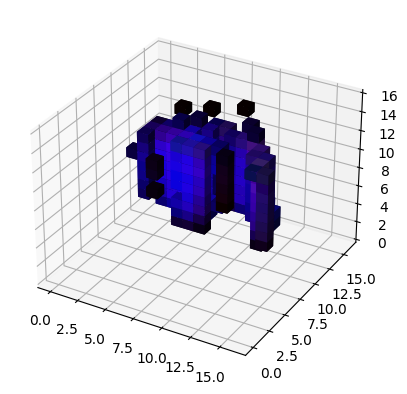

 42%|████▏     | 1700/4001 [19:51<26:23,  1.45it/s]

T_loss: -74.1219482421875;  f_loss: -10.555320739746094


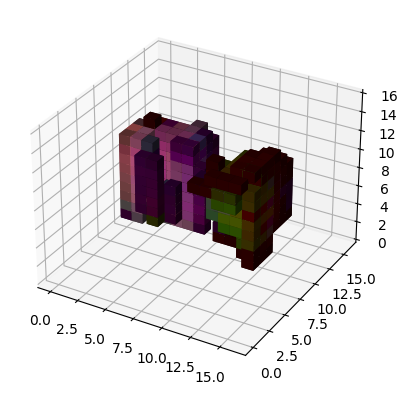

 45%|████▍     | 1800/4001 [21:01<25:33,  1.44it/s]

T_loss: 7.89871883392334;  f_loss: -7.537184715270996


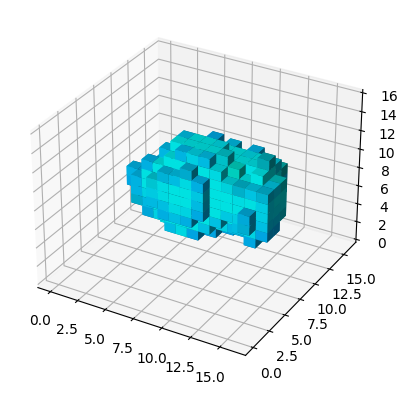

 47%|████▋     | 1900/4001 [22:11<24:29,  1.43it/s]

T_loss: 10773.5615234375;  f_loss: -5322.2734375


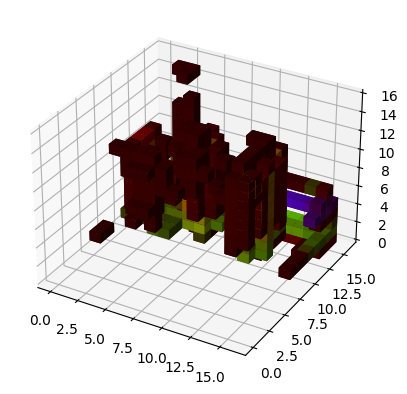

 50%|████▉     | 2000/4001 [23:21<23:17,  1.43it/s]

T_loss: 1485.04150390625;  f_loss: 66.330078125


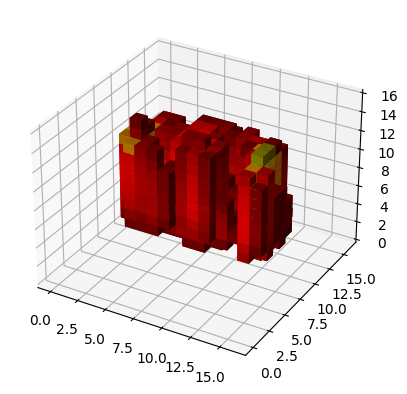

 52%|█████▏    | 2100/4001 [24:32<22:07,  1.43it/s]

T_loss: 868.5137939453125;  f_loss: -23.09356689453125


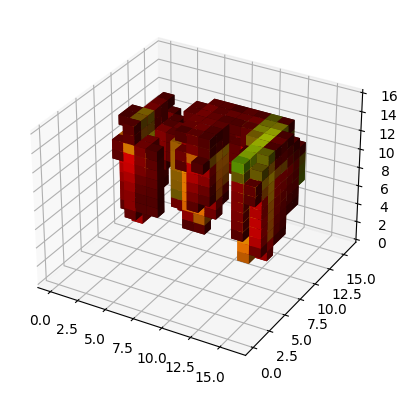

 55%|█████▍    | 2200/4001 [25:42<20:50,  1.44it/s]

T_loss: 1355.229736328125;  f_loss: -19.046142578125


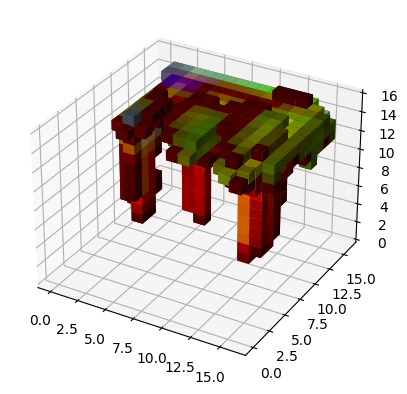

 57%|█████▋    | 2300/4001 [26:52<19:47,  1.43it/s]

T_loss: 1348.32177734375;  f_loss: -14.2415771484375


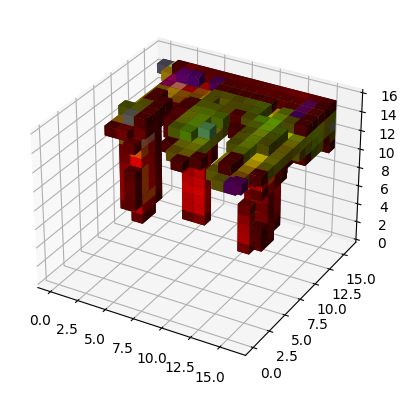

 60%|█████▉    | 2400/4001 [28:02<18:38,  1.43it/s]

T_loss: 1336.290283203125;  f_loss: -20.3221435546875


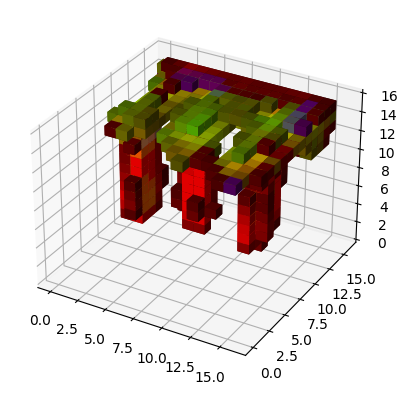

 62%|██████▏   | 2500/4001 [29:13<17:27,  1.43it/s]

T_loss: 1508.7579345703125;  f_loss: -93.5389404296875


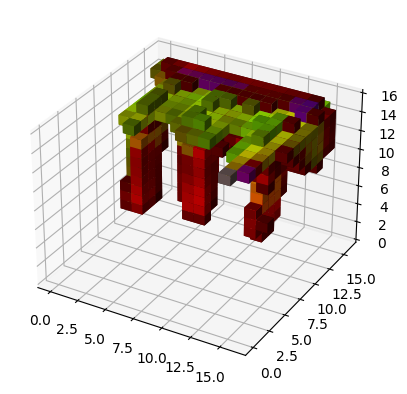

 65%|██████▍   | 2600/4001 [30:23<16:17,  1.43it/s]

T_loss: 2353.359619140625;  f_loss: -48.023681640625


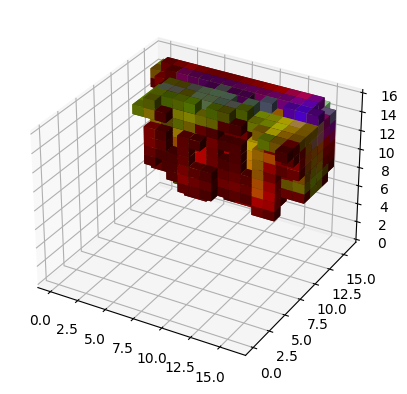

 67%|██████▋   | 2700/4001 [31:33<15:08,  1.43it/s]

T_loss: 3601.5732421875;  f_loss: -68.12158203125


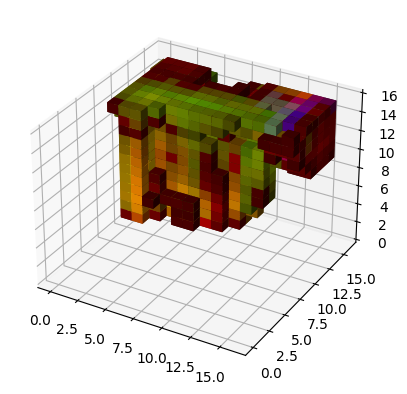

 70%|██████▉   | 2800/4001 [32:43<13:58,  1.43it/s]

T_loss: 114.03174591064453;  f_loss: -35.67095947265625


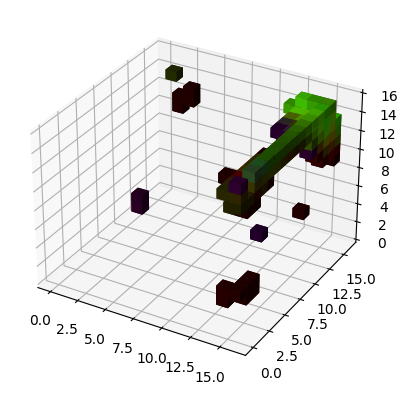

 72%|███████▏  | 2900/4001 [33:53<12:45,  1.44it/s]

T_loss: 191.45228576660156;  f_loss: -6.59014892578125


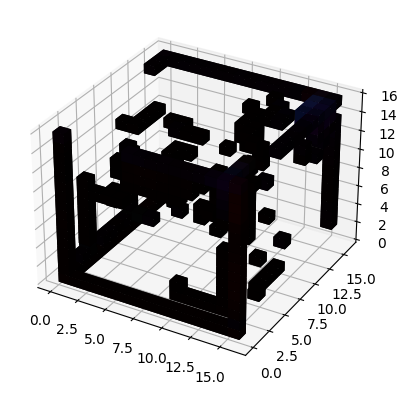

 75%|███████▍  | 3000/4001 [35:03<11:38,  1.43it/s]

T_loss: 133.79454040527344;  f_loss: -1.308380126953125


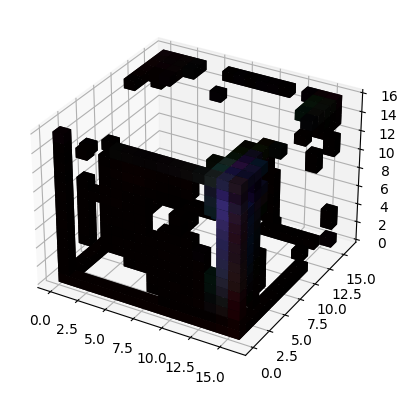

 77%|███████▋  | 3100/4001 [36:14<10:29,  1.43it/s]

T_loss: 93.7266616821289;  f_loss: 9.773597717285156


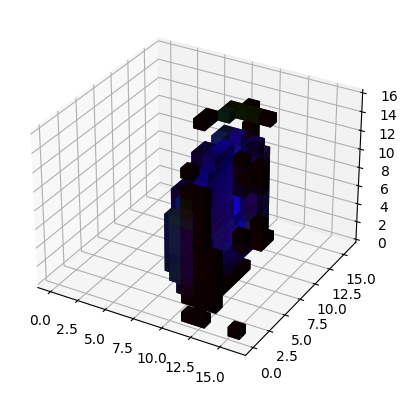

 80%|███████▉  | 3200/4001 [37:24<09:18,  1.44it/s]

T_loss: 63.700050354003906;  f_loss: 5.703739166259766


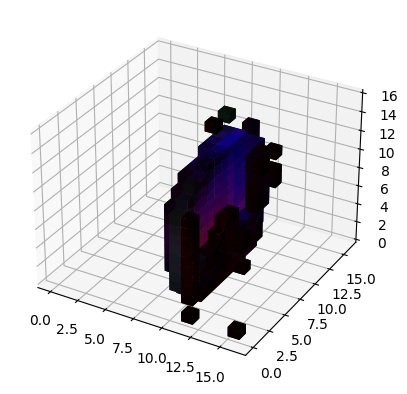

 82%|████████▏ | 3300/4001 [38:34<08:06,  1.44it/s]

T_loss: 21.628734588623047;  f_loss: 3.8781070709228516


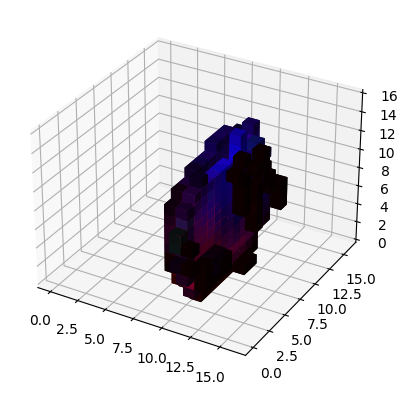

 85%|████████▍ | 3400/4001 [39:44<06:53,  1.45it/s]

T_loss: 14.979157447814941;  f_loss: 1.4359722137451172


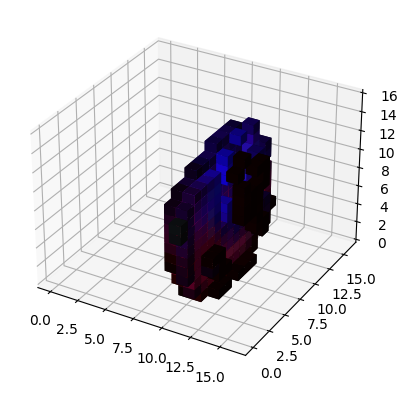

 87%|████████▋ | 3500/4001 [40:54<05:49,  1.43it/s]

T_loss: 11.473977088928223;  f_loss: 1.0298490524291992


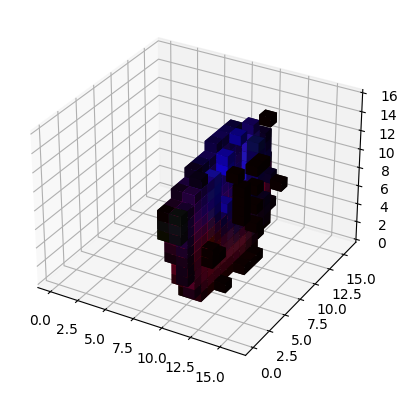

 90%|████████▉ | 3600/4001 [42:04<04:39,  1.43it/s]

T_loss: 8.662253379821777;  f_loss: 0.8387165069580078


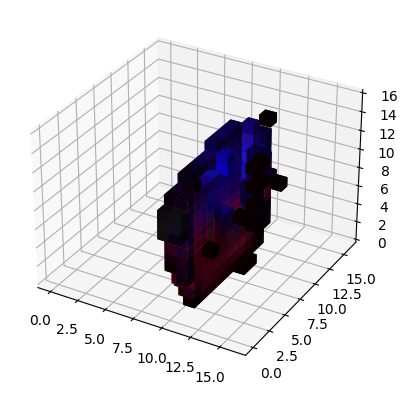

 92%|█████████▏| 3700/4001 [43:14<03:29,  1.43it/s]

T_loss: 6.932559013366699;  f_loss: 0.692725658416748


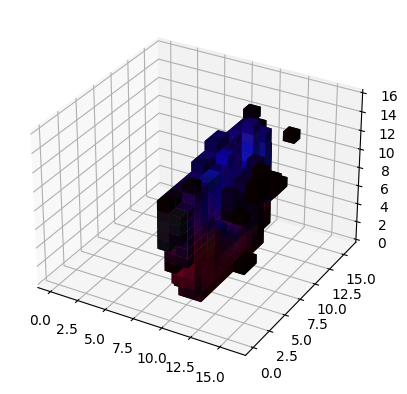

 95%|█████████▍| 3800/4001 [44:24<02:20,  1.43it/s]

T_loss: 6.113245487213135;  f_loss: 0.7364406585693359


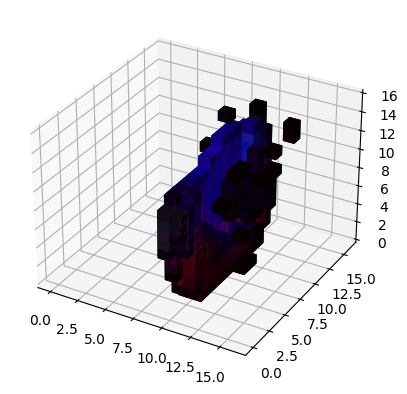

 97%|█████████▋| 3900/4001 [45:34<01:10,  1.43it/s]

T_loss: 5.579540729522705;  f_loss: 0.7865204811096191


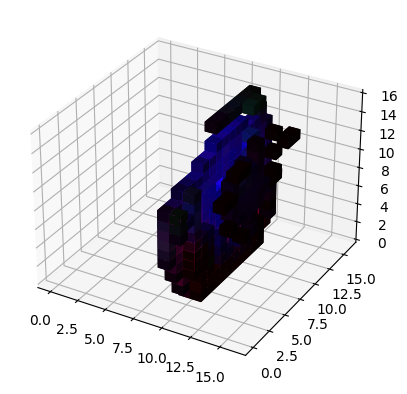

100%|█████████▉| 4000/4001 [46:44<00:00,  1.44it/s]

T_loss: 4.674276351928711;  f_loss: 0.6602363586425781


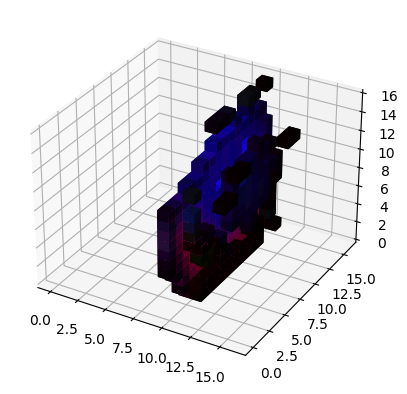

100%|██████████| 4001/4001 [46:46<00:00,  1.43it/s]


In [13]:
test_batch = sample_test()
plot_img(test_batch[0])
f_losses = []
T_losses = []

imgs = []

for step in tqdm(range(4001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.cuda())[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        save_model(step, T, f, T_opt, f_opt, T_loss, f_loss, f"weights/OT_ours_rotation{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [18]:
test_batch = sample_test().cuda()

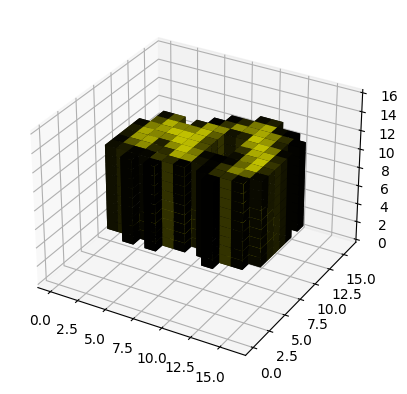

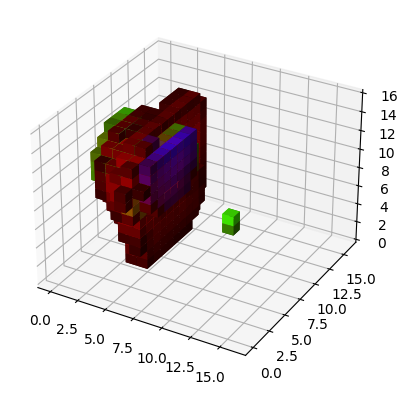

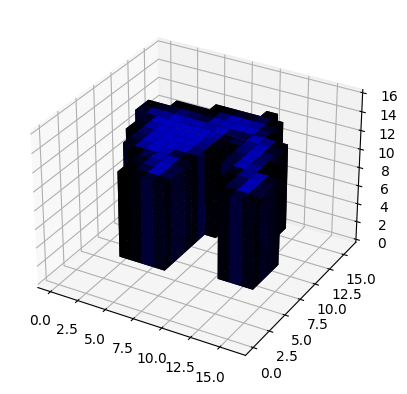

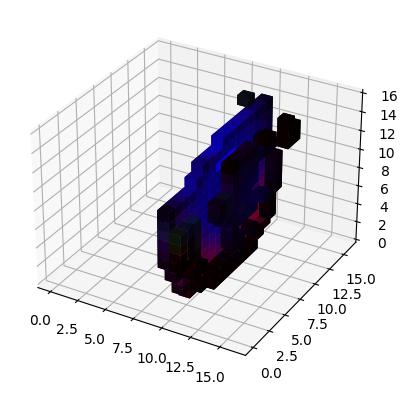

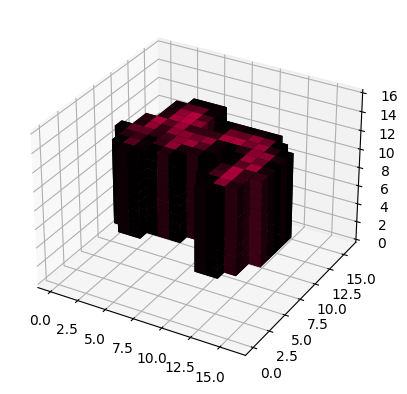

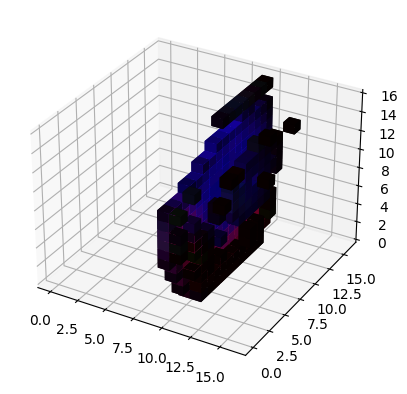

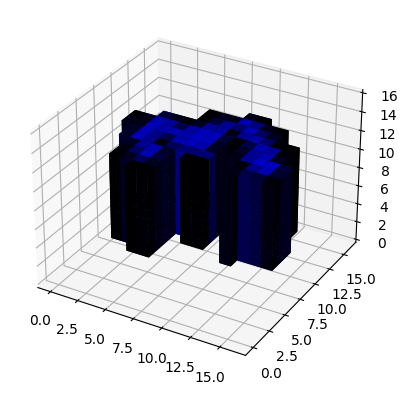

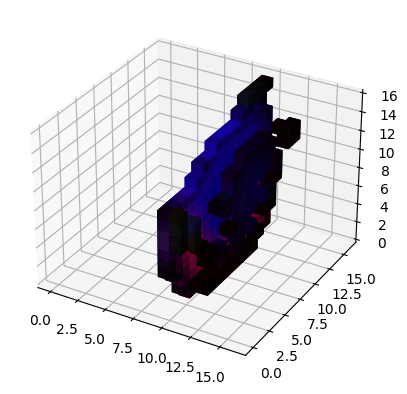

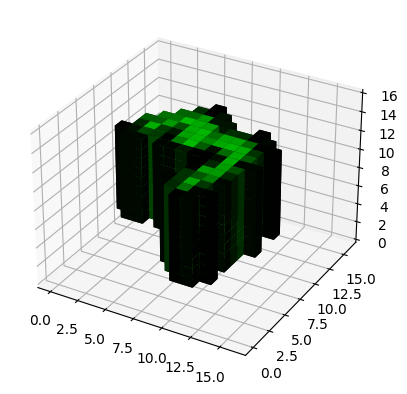

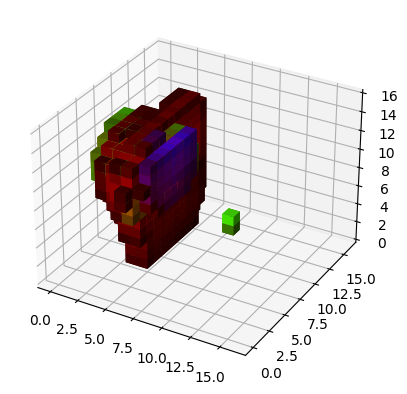

In [19]:
for i in range(5):
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)